In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

In [16]:
img_size=[640,192]
device = torch.device('cuda')

In [17]:
import timm
darknet53 = timm.create_model('darknet53', pretrained=False, features_only=True)

In [18]:
darknet53.load_state_dict(torch.load("darknet53_feat.pth"))

/tmp/ipykernel_10949/170986702.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  darknet53.load_state_dict(torch.load("darknet53_feat.pth"))


<All keys matched successfully>

In [19]:
class YOLO(nn.Module):
    def __init__(self,num_classes=9,freeze_backbone=True,darknet=True):
        super(YOLO, self).__init__()
        self.model_url = ""
        self.relu = torch.nn.ReLU(inplace=False)
        self.prediction=5+num_classes
        self.darknet=darknet
        self.conv1 = torch.nn.Conv2d(3,32,kernel_size=4,padding=1, stride=2)
        self.batch_norm1 = torch.nn.BatchNorm2d(32,eps=1e-05,momentum=0.1,
                                                affine=True,track_running_stats=True)
        
        self.conv2 = torch.nn.Conv2d(32,64,kernel_size=4,padding=1, stride=2)
        self.batch_norm2 = torch.nn.BatchNorm2d(64,eps=1e-05,momentum=0.1,
                                                affine=True,track_running_stats=True)

        self.conv3 = torch.nn.Conv2d(64,128,kernel_size=4,padding=1, stride=2)
        self.batch_norm3 = torch.nn.BatchNorm2d(128,eps=1e-05,momentum=0.1,
                                                affine=True,track_running_stats=True)
        
        self.conv4 = torch.nn.Conv2d(128, 256, kernel_size=4,padding=1, stride=2)
        self.batch_norm4 = torch.nn.BatchNorm2d(256,eps=1e-05,momentum=0.1,
                                                affine=True,track_running_stats=True)
        
        self.conv5 = torch.nn.Conv2d(256,512,kernel_size=4,padding=1, stride=2)
        self.batch_norm5 = torch.nn.BatchNorm2d(512,eps=1e-05,momentum=0.1,
                                                affine=True,track_running_stats=True)
        
        self.conv6 = torch.nn.Conv2d(512,1024, kernel_size=4,padding=1, stride=2)
        self.batch_norm6 = torch.nn.BatchNorm2d(1024, eps=1e-05,momentum=0.1,
                                                affine=True,track_running_stats=True)

        self.conv7 = torch.nn.ConvTranspose2d(1024, 512, kernel_size=4,padding=1, stride=2)
        self.batch_norm7 = torch.nn.BatchNorm2d(512, eps=1e-05,momentum=0.1,
                                                affine=True,track_running_stats=True)
        
        self.conv8 = torch.nn.ConvTranspose2d(512, 64, kernel_size=4,padding=1, stride=2)
        self.batch_norm8 = torch.nn.BatchNorm2d(64, eps=1e-05,momentum=0.1,
                                                affine=True,track_running_stats=True)

        self.conv9 = torch.nn.Conv2d(64, self.prediction, kernel_size=3, padding=1, stride=1)
        self.backbone=darknet53    
        
        if freeze_backbone:
            for param in self.backbone.parameters():
                param.requires_grad = False
        num_pred=14
        self.ml_pred=nn.Conv2d(64, self.prediction, kernel_size=1, stride=1)
        self.dark_conv=nn.Conv2d(512, 64, kernel_size=1, stride=1)

    def forward(self, x):
        if self.darknet:
            out=self.backbone.forward(x)
            out=(self.dark_conv(out[4]))
            return torch.sigmoid(self.ml_pred(out))
        
        layer1 = self.relu(self.batch_norm1(self.conv1(x)))
        layer2 = self.relu(self.batch_norm2(self.conv2(layer1)))
        layer3 = self.relu(self.batch_norm3(self.conv3(layer2)))
        layer4 = self.relu(self.batch_norm4(self.conv4(layer3)))
        layer5 = self.relu(self.batch_norm5(self.conv5(layer4)))
        layer6 = self.relu(self.batch_norm6(self.conv6(layer5)))
        layer7 = self.relu(self.batch_norm7(self.conv7(layer6)))
        layer8 = self.relu(self.batch_norm8(self.conv8(layer7)))
        out = torch.sigmoid(self.conv9(layer8))
        return out      

In [20]:
x=torch.randn(1, 3, 640, 192)
model=YOLO(num_classes=9,darknet=False)
print(model(x).shape)

torch.Size([1, 14, 40, 12])


In [21]:
def process_labels(target,batch_size,num_prediction=9):
    target = np.array(target.to('cpu'), dtype=np.float32)  # shape: (N, 6)
    b, cls, x1, y1, x2, y2 = target.T

    # Initialize once
    batch_target = np.zeros((batch_size, 14, 40,12), dtype=np.float32)

    # Vectorize computation of coordinates
    W, H = img_size
    cell_w,cell_h=[640/40,192/12]
    cx, cy = (x1 + x2) / 2, (y1 + y2) / 2
    grid_x, grid_y = (cx / cell_w).astype(int), (cy / cell_h).astype(int)
    c_grid_x, c_grid_y = (cx / cell_w)-grid_x, ((cy / cell_h))-grid_y
    w, h = (x2 - x1) / W, (y2 - y1) / H

    # Assign everything in a batched manner
    # print(b)
    batch_target[b.astype(int)-1, 0, grid_x, grid_y] = 1
    batch_target[b.astype(int)-1, 1, grid_x, grid_y] = c_grid_x
    batch_target[b.astype(int)-1, 2, grid_x, grid_y] = c_grid_y
    batch_target[b.astype(int)-1, 3, grid_x, grid_y] = w
    batch_target[b.astype(int)-1, 4, grid_x, grid_y] = h

    # One-hot for class predictions
    for i in range(len(cls)):
        batch_target[int(b[i]), 5 + int(cls[i]), grid_x[i], grid_y[i]] = 1
    # print(batch_target.shape)
    return batch_target

In [22]:
def bbox_iou(box1, box2,obj_idx, eps=1e-7):
   
    cpx, cpy, pw, ph = box1[:, 0], box1[:, 1], box1[:, 2], box1[:, 3]
    cx, cy, w, h = box2[:, 0], box2[:, 1], box2[:, 2], box2[:, 3]
    W,H=img_size
    pw=pw*W
    ph=ph*H
    w*=W
    h*=H

    cpx=cpx*16 + obj_idx[:,1]*16
    cpy=cpy*16+obj_idx[:,2]*16
    cx=cx*16 + obj_idx[:,1]*16
    cy=cy*16+obj_idx[:,2]*16

    box1 =  [cpx-pw/2, cpy-ph/2, cpx+pw/2, cpy+ph/2]
    box2 =  [cx-w/2, cy-h/2, cx+w/2, cy+h/2]

    xA = torch.max(box1[0], box2[0])
    yA = torch.max(box1[1], box2[1])

    xB = torch.min(box1[2], box2[2])
    yB = torch.min(box1[3], box2[3])
    
    # union
    area_intersection = torch.max(xB-xA, torch.zeros(xB.shape, dtype=xB.dtype, device=xB.device)) * torch.max(yB-yA, torch.zeros(yB.shape, dtype=yB.dtype, device=yB.device))

    area_union = (box1[2]-box1[0]) * (box1[3]-box1[1]) + (box2[2]-box2[0]) * (box2[3]-box2[1]) - area_intersection +eps

    iou = torch.clamp(area_intersection / (area_union ), 0, 1)
    return iou

In [23]:
def yolo_loss(output, target, num_prediction=9):
    batch_size=output.shape[0]
    new_target=torch.tensor(process_labels(target,batch_size)).to(device) #-->(B,5+num_pred,20,8)
    
    object_idx=new_target[:,0,:,:].nonzero()
    no_object_idx=(new_target[:,0,:,:]==0).nonzero()
    
    # print(object_idx.shape)
    target_obj=new_target[object_idx[:,0],:,object_idx[:,1],object_idx[:,2]]
    predicted_object = output[object_idx[:,0],:,object_idx[:,1],object_idx[:,2]]

    predicted_no_object = output[no_object_idx[:,0],:,no_object_idx[:,1],no_object_idx[:,2]]

    localization_loss = torch.sum((target_obj[:,1]-predicted_object[:,1])**2 +
                                  (target_obj[:,2]-predicted_object[:,2])**2)

    bbox_loss         = torch.sum((torch.sqrt(target_obj[:,3])-torch.sqrt(predicted_object[:,3]))**2 +
                                  (torch.sqrt(target_obj[:,4])-torch.sqrt(predicted_object[:,4]))**2)
    
    pc_loss = torch.sum((target_obj[:,5:]-predicted_object[:,5:])**2)
    
    ### IOU 
    iou=bbox_iou(predicted_object[:,1:5],target_obj[:,1:5],object_idx)

    obj_conf_loss=torch.sum((iou.detach()-predicted_object[:,0])**2)
    nobj_confidence_loss= torch.sum((0 - predicted_no_object[:, 0])**2)

    loss = 5.0*(localization_loss + bbox_loss) + obj_conf_loss + 0.5*nobj_confidence_loss + pc_loss
    # print(localization_loss,obj_conf_loss)
    return loss



In [24]:
def collate_fn(batch):
    imgs = []
    targets = []
    for i, (img, labels) in enumerate(batch):
        imgs.append(img)

        if labels.numel() > 0:
            # add batch index column
            batch_idx = torch.full((labels.shape[0], 1), i) 
            labels = torch.cat((batch_idx, labels), dim=1)
            targets.append(labels)

    imgs = torch.stack(imgs)
    if len(targets):
        targets = torch.cat(targets, dim=0)
    else:
        targets = torch.zeros((0, 6))
    return imgs, targets

In [25]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torch
import os
from torchvision import transforms

class YOLODataset(Dataset):
    def __init__(self, img_dir, label_dir, img_size=(640,192), transform=None):
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.img_files = [f for f in os.listdir(img_dir) if f.endswith(".jpg")]
        self.img_size = img_size
        self.transform = transforms.ToTensor()

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        img_name = self.img_files[idx]
        img_path = os.path.join(self.img_dir, img_name)
        label_path = os.path.join(self.label_dir, img_name.replace(".jpg", ".txt"))

        # --- Load and normalize image ---
        image = Image.open(img_path).convert("RGB")
        image = self.transform(image)  # shape: [3, H, W], range [0,1]
        image=image.permute(0,2,1)
        # --- Load YOLO labels ---
        boxes = []
        if os.path.exists(label_path):
            with open(label_path, "r") as f:
                for line in f:
                    parts = line.strip().split()
                    cls, x1, y1, x2, y2 = map(float, parts)
                    boxes.append([cls, x1, y1, x2, y2])

        if len(boxes) == 0:
            boxes = torch.zeros((0, 5), dtype=torch.float32)
        else:
            boxes = torch.tensor(boxes, dtype=torch.float32)

        return image, boxes
    
dataset = YOLODataset("../data/640x192/images", "../data/640x192/label")
loader = DataLoader(dataset, batch_size=32, shuffle=True,collate_fn=collate_fn)

Starting training on cuda
[Epoch 1/10] [Batch 0/234] Loss: 3720.4390
[Epoch 1/10] [Batch 100/234] Loss: 329.9044
[Epoch 1/10] [Batch 200/234] Loss: 269.3979
Epoch [1/10] Avg Loss: 636.5117
[Epoch 2/10] [Batch 0/234] Loss: 294.0777
[Epoch 2/10] [Batch 100/234] Loss: 326.2077
[Epoch 2/10] [Batch 200/234] Loss: 293.6234
Epoch [2/10] Avg Loss: 281.8265
[Epoch 3/10] [Batch 0/234] Loss: 275.1277
[Epoch 3/10] [Batch 100/234] Loss: 263.3170
[Epoch 3/10] [Batch 200/234] Loss: 273.8727
Epoch [3/10] Avg Loss: 265.9842
[Epoch 4/10] [Batch 0/234] Loss: 268.2137
[Epoch 4/10] [Batch 100/234] Loss: 266.3116
[Epoch 4/10] [Batch 200/234] Loss: 289.6103
Epoch [4/10] Avg Loss: 259.7702
[Epoch 5/10] [Batch 0/234] Loss: 242.5409
[Epoch 5/10] [Batch 100/234] Loss: 241.2550
[Epoch 5/10] [Batch 200/234] Loss: 247.2923
Epoch [5/10] Avg Loss: 255.6976
[Epoch 6/10] [Batch 0/234] Loss: 239.3601
[Epoch 6/10] [Batch 100/234] Loss: 254.5655
[Epoch 6/10] [Batch 200/234] Loss: 257.2122
Epoch [6/10] Avg Loss: 253.0698
[

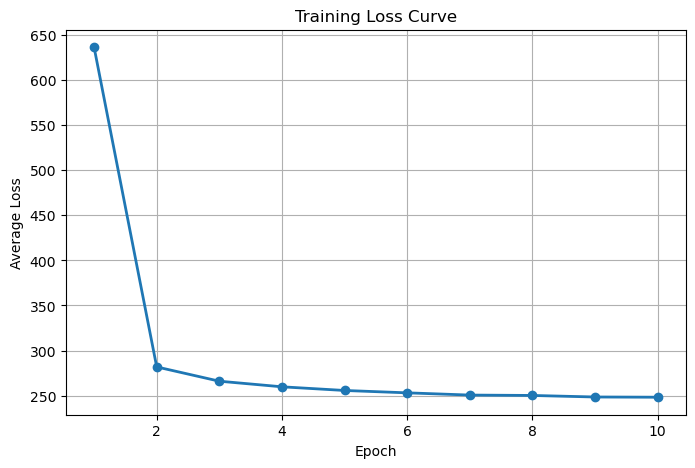

Starting training on cuda
[Epoch 1/10] [Batch 0/234] Loss: 266.5032
[Epoch 1/10] [Batch 100/234] Loss: 223.9904
[Epoch 1/10] [Batch 200/234] Loss: 264.7660
Epoch [1/10] Avg Loss: 248.1627
[Epoch 2/10] [Batch 0/234] Loss: 261.3462


KeyboardInterrupt: 

In [26]:


# --- Model / Loss / Optimizer ---
model = YOLO(num_classes=9).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

model.train()

import torch
import matplotlib.pyplot as plt
from torch.amp import autocast, GradScaler

# =========================
# TRAINING CONFIG
# =========================
num_epochs = 10

# --- Model / Loss / Optimizer ---
model = YOLO(num_classes=9).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

model.train()

import torch
import matplotlib.pyplot as plt
from torch.amp import autocast, GradScaler

# =========================
# TRAINING CONFIG
# =========================
num_epochs = 10
log_interval = 100  # print every N batches
scaler = GradScaler(device)

train_losses = []

print(f"Starting training on {device}")

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0

    for batch_idx, (imgs, targets) in enumerate(loader):
        # -----------------------------
        # Move to GPU
        # -----------------------------
        imgs = imgs.to(device, non_blocking=True)
        targets = targets.to(device, non_blocking=True)  # [batch_id, cls, x, y, w, h]

        optimizer.zero_grad(set_to_none=True)

        # -----------------------------
        # Forward + Loss (with AMP)
        # -----------------------------
        with autocast("cuda"):
            out = model(imgs)
            # print(imgs.shape)
            # print(targets.shape) #([N, 6]) -> (B, cls,cx,cy,w,h)
            # print(out.shape)
            
        loss=yolo_loss(out,targets)
        # # -----------------------------
        # # Backward + Step
        # # -----------------------------
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # # -----------------------------
        # # Logging
        # # -----------------------------
        epoch_loss += loss.item()

        if batch_idx % log_interval == 0:
            print(
                f"[Epoch {epoch+1}/{num_epochs}] "
                f"[Batch {batch_idx}/{len(loader)}] "
                f"Loss: {loss.item():.4f}"
            )

        # # cleanup
        # del imgs, targets, out
        torch.cuda.empty_cache()

    # -----------------------------
    # Epoch summary
    # -----------------------------
    avg_loss = epoch_loss / len(loader)
    train_losses.append(avg_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}] Avg Loss: {avg_loss:.4f}")

# =========================
# PLOT LOSS CURVE
# =========================
plt.figure(figsize=(8,5))
plt.plot(range(1, num_epochs + 1), train_losses, marker='o', linewidth=2)
plt.title("Training Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Average Loss")
plt.grid(True)
plt.show()
log_interval = 100  # print every N batches
scaler = GradScaler(device)

train_losses = []

print(f"Starting training on {device}")

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0

    for batch_idx, (imgs, targets) in enumerate(loader):
        # -----------------------------
        # Move to GPU
        # -----------------------------
        imgs = imgs.to(device, non_blocking=True)
        targets = targets.to(device, non_blocking=True)  # [batch_id, cls, x, y, w, h]

        optimizer.zero_grad(set_to_none=True)

        # -----------------------------
        # Forward + Loss (with AMP)
        # -----------------------------
        with autocast("cuda"):
            out = model(imgs)
            # print(imgs.shape)
            # print(targets.shape) #([N, 6]) -> (B, cls,cx,cy,w,h)
            # print(out.shape)
            
        loss=yolo_loss(out,targets)
        # # -----------------------------
        # # Backward + Step
        # # -----------------------------
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # # -----------------------------
        # # Logging
        # # -----------------------------
        epoch_loss += loss.item()

        if batch_idx % log_interval == 0:
            print(
                f"[Epoch {epoch+1}/{num_epochs}] "
                f"[Batch {batch_idx}/{len(loader)}] "
                f"Loss: {loss.item():.4f}"
            )

        # # cleanup
        # del imgs, targets, out
        torch.cuda.empty_cache()

    # -----------------------------
    # Epoch summary
    # -----------------------------
    avg_loss = epoch_loss / len(loader)
    train_losses.append(avg_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}] Avg Loss: {avg_loss:.4f}")

# =========================
# PLOT LOSS CURVE
# =========================
plt.figure(figsize=(8,5))
plt.plot(range(1, num_epochs + 1), train_losses, marker='o', linewidth=2)
plt.title("Training Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Average Loss")
plt.grid(True)
plt.show()

In [ ]:
# model=YOLO(num_classes=9)
# model.load_state_dict(torch.load("./yolov1.pth",weights_only=True))

<All keys matched successfully>

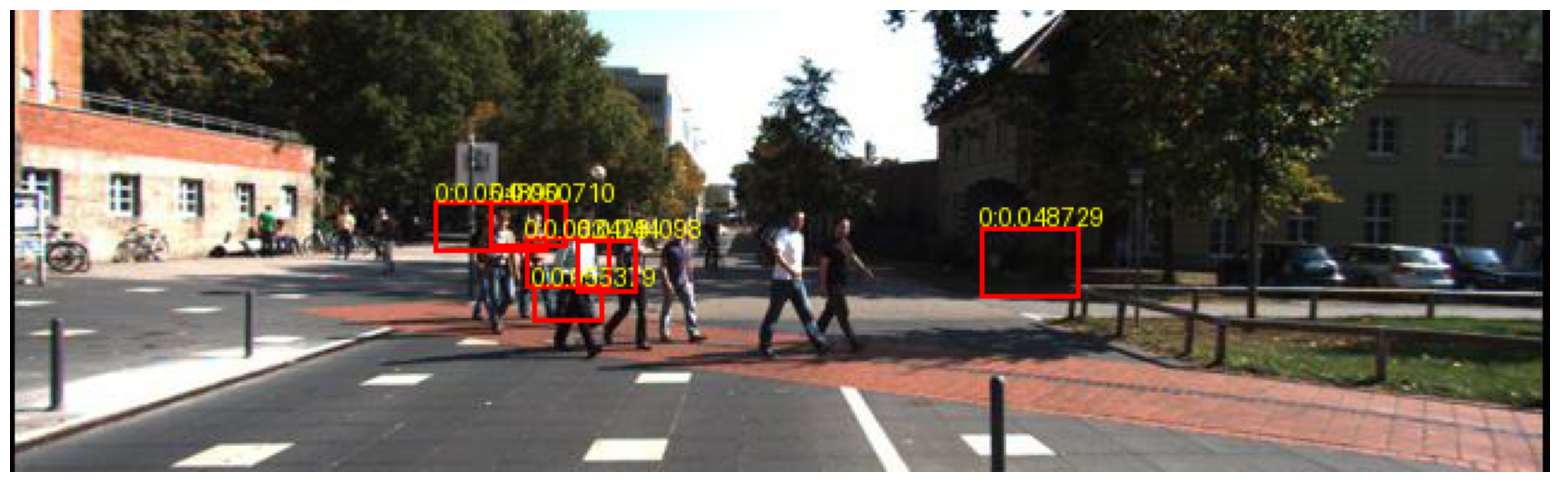

torch.Size([14, 40, 12])


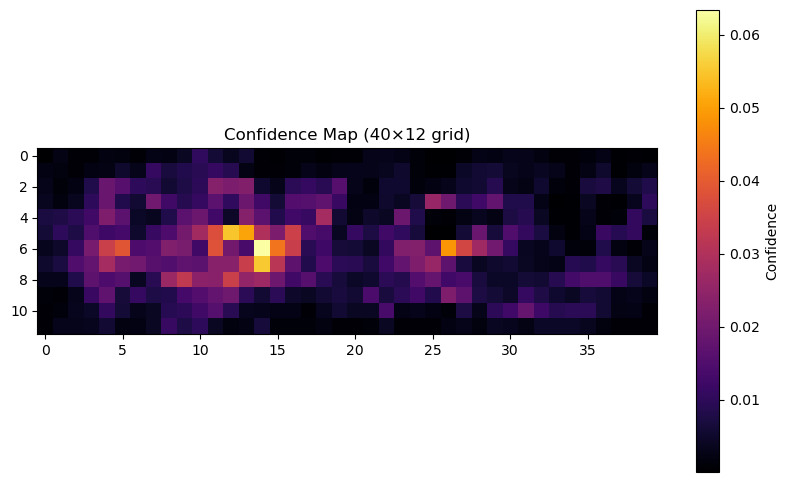

In [39]:
import torch
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
import os
import random

# ======= CONFIG =======
IMG_PATH = "./data/640x192/images"   # change this

NUM_CLASSES = 9
S = 20  # your grid size

IMG_SIZE = (640, 192)

# ======= LOAD MODEL =======
device = "cuda" if torch.cuda.is_available() else "cpu"

model.eval()

# ======= PREPROCESS IMAGE =======


IMG_DIR = "../data/640x192/images"
device = "cuda" if torch.cuda.is_available() else "cpu"

# pick a random image file
img_name = random.choice([f for f in os.listdir(IMG_DIR) if f.endswith((".jpg", ".png"))])
# img_name='000423.jpg'
img_path = os.path.join(IMG_DIR, img_name)

# open and preprocess image
img = Image.open(img_path).convert("RGB")
img_tensor = (
    torch.from_numpy(np.array(img)).permute(2, 0, 1).float() / 255.0
).unsqueeze(0).to(device) 

img_tensor=img_tensor.permute(0,1,3,2)
# ======= INFERENCE =======
with torch.no_grad():
    preds = model(img_tensor)[0]  # (C, S, S)

conf = preds[0]        # confidence map
x = preds[1]
y = preds[2]
w = preds[3]
h = preds[4]
cls_scores = torch.softmax(preds[5:], dim=0)

# ======= DECODE BOXES =======
boxes = []
for i in range(40):
    for j in range(12):
        if conf[i, j] > 0.04:
            cx = (i + x[i, j]) * (640/40)
            cy = (j + y[i, j]) * (192/12)
            bw = w[i, j] * IMG_SIZE[0]
            bh = h[i, j] * IMG_SIZE[1]

            x1 = cx - bw / 2
            y1 = cy - bh / 2
            x2 = cx + bw / 2
            y2 = cy + bh / 2

            cls_idx = torch.argmax(cls_scores[:, i, j]).item()
            boxes.append((x1, y1, x2, y2, cls_idx, conf[i, j].item()))

# # ======= VISUALIZE =======
draw = ImageDraw.Draw(img)
for (x1, y1, x2, y2, cls, conf) in boxes:
    draw.rectangle([x1, y1, x2, y2], outline="red", width=2)
    draw.text((x1, y1 - 10), f"{cls}:{conf:.6f}", fill="yellow")

plt.figure(figsize=(20, 6))
plt.imshow(img)
plt.axis("off")
plt.show()

import matplotlib.pyplot as plt

print(preds.shape)

plt.figure(figsize=(10, 6))
plt.imshow(preds[0,:].permute(1,0).cpu(), cmap='inferno', interpolation='nearest')
plt.colorbar(label='Confidence')
plt.title("Confidence Map (40×12 grid)")
plt.show()
